## Importing Libraries

In [ ]:
# Importing libraries

# Math Libraries
import random
import math
import numpy as np

# Data Processing
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt  
import seaborn as sns 

# ML
from sklearn.linear_model import LogisticRegression # Importing Logistic Model
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.preprocessing import MinMaxScaler # Data normalizer Min Max Scale
from sklearn.metrics import accuracy_score # Calculate the accuracy

# Loading Bar
from time import sleep
from tqdm import tqdm

# Supress warnings
import warnings; warnings.simplefilter('ignore')


## Global Functions

In [ ]:
# Defining the upper and lower bound for MSE in BoP
def upper(d, m):
  return math.log(d) / (m) + np.log(m) / m + (1 + math.log(2)) / m
def lower(d, m):
  return math.log(d) / (16 * m) - (math.log(4)) / (16 * m)

In [ ]:
def get_mean(df: pd.DataFrame,significants: list,  groups: list, dpg: int) -> float:
  sample_size = random.randrange(dpg)
  estimated_mean = []
  for group in significants:
    aux = df[((df[groups]).sum(axis = 1)) == group].reset_index()
    data = (aux).loc[np.random.choice(np.arange(len(aux)), size=sample_size)]
    estimated_mean.append(data['performance difference'].mean())
  return estimated_mean

In [ ]:
def error_count(true_gamma: float, est_gamma: float, epsilon: np.array) -> float:
  size_eps = epsilon.size
  error = np.zeros(size_eps)
  for i in range(size_eps):
    if epsilon[i] > true_gamma:
      error[i] = 1 - (est_gamma < epsilon[i])*1
    else:
      error[i] = 1 - (est_gamma >= epsilon[i])*1
  return error

In [ ]:
# Defining function that generates a dataset with m data points in each group
def get_sim_dataset(df: pd.DataFrame, m: int, significants: list, groups: list,  set_seed: bool) -> pd.DataFrame:
  new_data = []
  if set_seed:
    j = 0
    for group in significants:
      aux = df[((df[groups]).sum(axis = 1)) == group].reset_index()
      np.random.seed(j)
      data = (aux).loc[np.random.choice(np.arange(len(aux)), size=m)]
      new_data.append(data)
      j = j+1
  else:
    for group in significants:
      aux = df[((df[groups]).sum(axis = 1)) == group].reset_index()
      data = (aux).loc[np.random.choice(np.arange(len(aux)), size=m)]
      new_data.append(data)

  return pd.concat(new_data)

## Experiments with Adult Dataset
Predict whether income is greater then $50k

### Preprocessing

In [ ]:
# Loading Datasets
adult_dataset = pd.read_csv('../Data/adult.csv') # Loading Adult
# adult_dataset = pd.read_csv('adult.csv') # Loading Adult

In [ ]:
def Adult_Data_Clean(df: pd.DataFrame) -> pd.DataFrame:
  # Changing collumn names for convenience
  df.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                    'hours-per-week': 'hours','marital-status': 'marital'}, inplace=True)
  
  # Finding not known data
  df['country'] = df['country'].replace('?',np.nan)
  df['workclass'] = df['workclass'].replace('?',np.nan)
  df['occupation'] = df['occupation'].replace('?',np.nan)
  
  # Dropping not known data
  df.dropna(how='any',inplace=True)

  # Normalizing numerical features
  numerical = ['age', 'fnlwgt', 'educational-num', 'gain', 'loss', 'hours']
  scaler = MinMaxScaler()
  df[numerical] = scaler.fit_transform(df[numerical])  
  return df

In [ ]:
# Cleaning adult dataset
adult_dataset = Adult_Data_Clean(adult_dataset)
adult_groups = ['workclass', 'education', 'marital', 'occupation', 'relationship', 'race', 'gender', 'country']

# Finding significant groups, i.e., counting samples per group.
adult_Counting_groups = adult_dataset.groupby(adult_groups).size().to_frame('m').reset_index()
adult_only_with_more = 50
significant_groups = adult_Counting_groups[adult_Counting_groups['m'] > adult_only_with_more]
adult_list_significant = (significant_groups[adult_groups]).sum(axis = 1).tolist()
d = len(adult_list_significant)

# Filtering for only groups with more than adult_only_with_more elements
adult_dataset = adult_dataset[ ((adult_dataset[adult_groups]).sum(axis = 1)).isin(adult_list_significant)]

# Separating label (income) from the rest of the data and making income binary
income_raw = adult_dataset['income'].tolist()
adult_dataset = adult_dataset.drop(['income'], axis=1)
income = pd.Series(income_raw).astype('category').cat.codes.tolist()

In [ ]:
print(d)

141


### Training personalized classifier (with group attributes) h_g

In [ ]:
# Defining dataset to be used in the personalized algorithm
per_adult_dataset = adult_dataset
# One-Hot encoding
per_adult_encoded = pd.get_dummies(per_adult_dataset)
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(per_adult_encoded, income, test_size = 0.5, random_state = 0)

In [ ]:
# Trining the Logistic regression classifier
logistic = LogisticRegression(solver = 'liblinear')
logistic.fit(X_train, Y_train)

#Predicting
y_test_pred = logistic.predict(X_test)
y_train_pred = logistic.predict(X_train)

In [ ]:
# Getting accuracy for the personalized classifier
per_train_acc = accuracy_score(Y_train, y_train_pred)
per_test_acc = accuracy_score(Y_test, y_test_pred)
per_train_acc, per_test_acc

(0.799521895034228, 0.7996523250760539)

### Training group-blind classifier (with group attributes) h_0

In [ ]:
# Dropping group features
gb_adult_dataset = adult_dataset[['age', 'gain', 'loss', 'hours']]

In [ ]:
# Spliting dataset (Here we are using the same split as in ther Personalized Model)
gb_X_train, gb_X_test = X_train[['age', 'gain', 'loss', 'hours']], X_test[['age', 'gain', 'loss', 'hours']]
gb_Y_train, gb_Y_test = Y_train, Y_test

In [ ]:
# Creating GB model
gb_logistic = LogisticRegression(solver = 'liblinear')
gb_logistic.fit(gb_X_train, gb_Y_train)

#Predicting
gb_y_test_pred = gb_logistic.predict(gb_X_test)
gb_y_train_pred = gb_logistic.predict(gb_X_train)

In [ ]:
# Accuracy group blind classifier
gb_train_acc = accuracy_score(gb_Y_train, gb_y_train_pred)
gb_test_acc = accuracy_score(gb_Y_test, gb_y_test_pred)
gb_train_acc, gb_test_acc

(0.7155275453656417, 0.7187092568448501)

### Analysis and Plots

We expect the accuracy for the group blind classifier to be smaller than the accuracy for the personalized classifier. 

Now, we will calculate the benefit of personalization. Note that here we don't have access to the true dataset distribution. Then we will resample from the test dataset $1000$ data points, estimate the BoP and define it as the group truth BoP.

For future estimations we will do the same procedure, we will resample $m$ samples with replacemente from the test dataset and estimate the BoP. 

In [ ]:
# Creating test dataframe only with group information, personalized prediction, and gb prediction

adult_pred_tabel = X_test # Only test data
adult_pred_tabel = adult_dataset.loc[adult_pred_tabel.index] 
adult_pred_tabel = adult_pred_tabel[adult_groups] # Only group attributes
GT_income = Y_test # Getting GT
GB_pred_income = gb_y_test_pred # GB prediction
Per_pred_income = y_test_pred # Personalized pred

# Canculating indicator of right prediction
adult_pred_tabel['GB Pred'] = 1 - (GT_income - GB_pred_income)**2
adult_pred_tabel['Per Pred'] =  1 - (GT_income - Per_pred_income)**2

#Generating a dataset with 1000 points per group
fake_true_data = get_sim_dataset(adult_pred_tabel, 1000, adult_list_significant, adult_groups, set_seed = True)

# Calculating accuracy for all significant groups
accuracy_per_group = fake_true_data.groupby(adult_groups).mean()

# Performance difference 
adult_pred_tabel['performance difference'] = adult_pred_tabel['Per Pred'] - adult_pred_tabel['GB Pred']

# BoP per group
BoP_Per_group = accuracy_per_group['Per Pred'] - accuracy_per_group['GB Pred']

# BoP
gamma = min(BoP_Per_group.tolist())
print('The BoP is:', gamma)

The BoP is: -0.09199999999999997


In [ ]:
accuracy_per_group['BoP_Per_Group'] = BoP_Per_group
groupMostHarmed = accuracy_per_group.idxmin().loc['BoP_Per_Group']
print(groupMostHarmed)
print(accuracy_per_group.index.names)

('Private', 'HS-grad', 'Married-civ-spouse', 'Tech-support', 'Husband', 'White', 'Male', 'United-States')
['workclass', 'education', 'marital', 'occupation', 'relationship', 'race', 'gender', 'country']


In [ ]:
# verify groupMostHarmed
print(accuracy_per_group.loc[groupMostHarmed]['BoP_Per_Group'] == gamma)

True


As we expect, for the Adult dataset, even knowing that the overall accuracy is bigger for the personalized algorithm, the BoP is negative. Then, there exists a group being **harmed**!

Now, Lets start to run our experiments for estimation of the BoP. 
We will resample with replacement $m$ samples per group.
After that, we will use Monte Carlo simulations to to calculate the BoP for a given $m$.

In [ ]:
montecarlo_it = 100
#qtd_per_group =np.array([10,20,50,100,200,500,1000])
qtd_per_group =np.array([10,25,50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 
                      500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])

gammas = np.zeros((qtd_per_group.size) * montecarlo_it)
data_per_group_est = np.zeros((qtd_per_group.size) * montecarlo_it)
j = 0
for i in tqdm(qtd_per_group):
  gamma_sum = 0
  for l in range(montecarlo_it):
    dataset_slice = get_sim_dataset(adult_pred_tabel, i, adult_list_significant, adult_groups, set_seed = False)
    slice_accuracy_per_group = dataset_slice.groupby(adult_groups).mean()
    gammas[j] = ( min(slice_accuracy_per_group['performance difference'].tolist()) - gamma) ** 2
    data_per_group_est[j] = i
    j = j+1

100%|██████████| 23/23 [1:03:12<00:00, 164.89s/it]


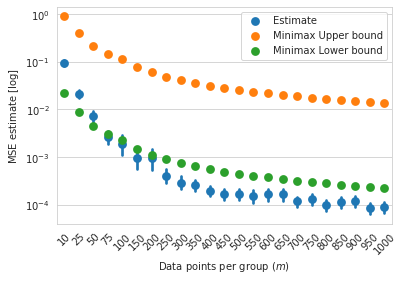

In [ ]:
with sns.axes_style("whitegrid"):

  m = qtd_per_group
  points_per_group_est = data_per_group_est
  points_MSE = np.stack((points_per_group_est, gammas), axis = 1)
  x_label = r'Data points per group ($m$)'
  y_label = r'MSE estimate [$\log$]'
  column_values = [x_label, y_label ]
  df = pd.DataFrame(data = points_MSE, 
                    columns = column_values)
  a_u = np.stack((qtd_per_group, upper(d, m)), axis = 1)
  a_l = np.stack((qtd_per_group, lower(d, m)), axis = 1)
  a_u = pd.DataFrame(data = a_u, 
                    columns = column_values)
  a_l = pd.DataFrame(data = a_l, 
                    columns = column_values)

  df['Type'] = 'Estimate'
  a_u['Type'] = 'Minimax Upper bound'
  a_l['Type'] = 'Minimax Lower bound'
  ax1 = sns.pointplot(data=pd.concat([df,a_u, a_l]), x=x_label, y=y_label, hue = 'Type', linestyles='', marker='o', errorbar=("pi", 10))
  handles, labels = ax1.get_legend_handles_labels()
  ax1.legend(handles=handles[0:], labels=labels[0:])


  plt.yscale('log')
  ax1.set_xticklabels(qtd_per_group, rotation=45)

  plt.savefig('MSE_log_bounds.pdf', bbox_inches='tight')

  #legend = ax.legend()
  #legend.texts[0]


In [ ]:
with sns.axes_style("whitegrid"):

  m = qtd_per_group
  points_per_group_est = data_per_group_est
  points_MSE = np.stack((points_per_group_est, gammas), axis = 1)
  x_label = r'Data points per group ($m$)'
  y_label = r'MSE estimation [$\log$]'
  column_values = [x_label, y_label ]
  df = pd.DataFrame(data = points_MSE, 
                    columns = column_values)
  a_u = np.stack((qtd_per_group, upper(d, m)), axis = 1)
  a_l = np.stack((qtd_per_group, lower(d, m)), axis = 1)
  a_u = pd.DataFrame(data = a_u, 
                    columns = column_values)
  a_l = pd.DataFrame(data = a_l, 
                    columns = column_values)

  df['Type'] = 'Estimation'
  a_u['Type'] = 'Upper bound'
  a_l['Type'] = 'Lower bound'
  ax1 = sns.pointplot(data=pd.concat([df]), x=x_label, y=y_label, hue = 'Type', linestyles='', marker='o', errorbar=("pi", 10))
  handles, labels = ax1.get_legend_handles_labels()
  ax1.legend(handles=handles[0:], labels=labels[0:])


  plt.yscale('log')
  ax1.set_xticklabels(qtd_per_group, rotation=45)

  plt.savefig('MSE_log.pdf', bbox_inches='tight')

  legend = ax.legend()
  legend.texts[0]


**Now**, we will run experiments for the hypothesis test. We will:


1.   Choose an $\epsilon$, run an threshold test with this epsilon, and plot the error probability of the test and our converse bound.
2.   We will create a heat-map to show the above experiment for different values of epsilon. 



In [ ]:
it_bootstrap = 100
epsilon = -0.15

qtd_per_group_prob = np.sort(np.array([10,20,50,100, 200,500,1000] + [d]))

per_group_num = np.zeros((qtd_per_group_prob.size)*it_bootstrap)
error_prob = np.zeros((qtd_per_group_prob.size)*it_bootstrap)
j = 0
for l in tqdm(qtd_per_group_prob):
  i = l
  error_prob_sum = 0
  dataset_slice = get_sim_dataset(adult_pred_tabel, i, adult_list_significant, adult_groups, set_seed = False)

  for k in range(it_bootstrap):
    slice_accuracy_per_group = get_mean(adult_pred_tabel, adult_list_significant,  adult_groups, i)
    aux_gamma = min(slice_accuracy_per_group) 
    error_prob_sum = error_count(gamma, aux_gamma, np.array([epsilon]))
    per_group_num[j] = i
    error_prob[j] = error_prob_sum
    j = j+1

100%|██████████| 8/8 [23:45<00:00, 178.24s/it]


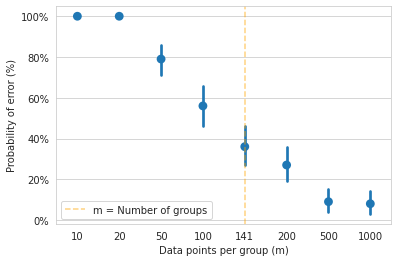

In [ ]:
import matplotlib.ticker as mtick
with sns.axes_style("whitegrid"):

  points_per_group = per_group_num
  points_error = np.stack((points_per_group, 100*error_prob.T), axis = 1)
  column_values = ['Data points per group (m)', 'Probability of error (%)']
  df = pd.DataFrame(data = points_error, 
                    columns = column_values)
  trans = np.where(d == qtd_per_group_prob)
  a = sns.pointplot(data=df, x=column_values[0], y=column_values[1], linestyles='', marker='o', edgecolor = 'black', linewidth = 1)
  a.yaxis.set_major_formatter(mtick.PercentFormatter())

  plt.axvline(trans, 0,100, color = 'orange', linestyle='--', alpha=0.5, label = 'm = Number of groups')
  plt.legend(loc='lower left')
  a.set_xticklabels(qtd_per_group_prob)
  plt.savefig('Phase_trans.pdf')

In [ ]:
it_bootstrap = 100
epsilon = np.array([-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2])
qtd_per_group =np.array([10,20,50,100,200,500,1000])

error_prob_Matrix = np.zeros((qtd_per_group.size, epsilon.size))
j = 0
k = 0
for i in tqdm(qtd_per_group):
  error_prob_sum = 0
  dataset_slice = get_sim_dataset(adult_pred_tabel, i, adult_list_significant, adult_groups, set_seed = False)

  for l in range(it_bootstrap):
    slice_accuracy_per_group = get_mean(adult_pred_tabel, adult_list_significant,  adult_groups, i)
    aux_gamma = min(slice_accuracy_per_group) 
    error_prob_sum += error_count(gamma, aux_gamma, epsilon)

  error_prob_Matrix[j, :] = error_prob_sum / it_bootstrap
  j = j+1

100%|██████████| 7/7 [21:25<00:00, 183.58s/it]


In [ ]:
sns.color_palette("vlag", as_cmap=True)
aux_prob_matrix = [[100 * l  for l in sub] for sub in error_prob_Matrix]

a = pd.DataFrame(aux_prob_matrix)

a = a.set_axis(epsilon, axis=1, inplace=False)
a = a.set_axis(qtd_per_group, axis=0, inplace=False)
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue') 
plt.rc('text', usetex='false') 
ax = sns.heatmap(a, annot=True, cmap = 'vlag',  fmt='g', linewidths=.2, cbar_kws={'label': 'Probability of Error (%)'})
plt.xlabel(r'Threshold Gain ($\epsilon$)')
plt.ylabel('Data Points per Group (m)')
ax.invert_yaxis()
fmt = '%.0f%%'
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
for t in ax.texts: t.set_text(t.get_text() + "%")  
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
plt.savefig('heat_map_notation.pdf', bbox_inches='tight' )

NameError: ignored

## Experiments with HSLS Dataset
Predict whether a student's 9th grade Math score is higher than the median.

### Preprocessing

In [ ]:
# Loading Datasets
df = pd.read_csv("../Data/hsls_condensed.csv")

In [ ]:
print(df.shape)

(23503, 43)


In [ ]:
# Defining relevant features
student_vars = ['X1SEX', 'X1RACE', 'X1MTHID', 'X1MTHUTI', 'X1MTHEFF', 'X1MTHINT','X1PAR1EDU', 'X1PAR2EDU', 
                'X1PAR1OCC2', 'X1PAR2OCC2', 'X1FAMINCOME',
                'S1ENGCOMP', 'S1MTHCOMP', 'S1SCICOMP', 'S1APCALC', 'S1IBCALC']

parent_vars = ['P1JOBNOW1', 'P1JOBONET1_STEM1', 'P1JOBONET2_STEM1','P1MTHHWEFF', 'P1SCIHWEFF', 'P1ENGHWEFF', 
               'P1MTHCOMP', 'P1SCICOMP', 'P1ENGCOMP', 'P1CAMPMS', 'P1CAMPOTH', 'P1NOOUTSCH', 'P1MUSEUM', 
               'P1COMPUTER', 'P1FIXED', 'P1SCIFAIR', 'P1SCIPROJ', 'P1STEMDISC', 'P1EDUASPIRE', 'P1EDUEXPECT']

grade_vars = ['X1TXMSCR']

school_vars = ['X1CONTROL', 'X1REGION', 'X1SCHOOLCLI', 'X1COUPERTEA', 'X1COUPERCOU', 'X1COUPERPRI']

all_vars = grade_vars+student_vars+parent_vars+school_vars

# Defining group features
hsls_groups = ['X1SEX', 'X1RACE', 'P1JOBNOW1', 'X1FAMINCOME']

In [ ]:
from numpy.ma.core import array
def hsls_clean(df: pd.DataFrame, gpfeature) -> pd.DataFrame:
  # Replace values <=-7 as nan
  df[df <= -7] = np.nan

  # Dropping rows that have missing values in group attributes
  ix = ~(df[hsls_groups].isna().any(axis=1))
  df_clean = df.loc[ix,:]

  # Impute nan with mean for non-group attributes
  df_clean.fillna(df_clean.median(),inplace = True)

  # Creating gradebin binary variable to replace raw score
  df_clean['gradebin'] = (df_clean['X1TXMSCR'] > df_clean['X1TXMSCR'].median()).astype(int)
  df_clean = df_clean.drop(columns='X1TXMSCR')

  # Scaling non-group features
  numerical = [feature for feature in all_vars if feature not in hsls_groups]
  numerical.remove('X1TXMSCR')
  numerical.append('gradebin')
  scaler = MinMaxScaler()
  df_clean[numerical] = scaler.fit_transform(df_clean[numerical])  

  return df_clean

In [ ]:
df_clean = hsls_clean(df,hsls_groups)
df_clean_str = df_clean.astype(str)

In [ ]:
# Finding significant groups, i.e., counting samples per group.
hsls_Counting_groups = df_clean.groupby(hsls_groups).size().to_frame('m').reset_index()
hsls_only_with_more = 50 #samples should exceed
hsls_significant_groups = hsls_Counting_groups[hsls_Counting_groups['m'] > hsls_only_with_more]
hsls_significant_groups = hsls_significant_groups.astype(str)
hsls_list_significant = (hsls_significant_groups[hsls_groups]).sum(axis = 1).tolist()

# Filtering for only groups with more than hsls_only_with_more elements
hsls_dataset = df_clean[ ((df_clean_str[hsls_groups]).sum(axis = 1)).isin(hsls_list_significant)]
hsls_dataset_str = hsls_dataset.astype(str)

# Separating label from the rest of the data
is_aboveAve = hsls_dataset['gradebin']
hsls_dataset = hsls_dataset.drop(['gradebin'], axis=1)

### Training Personalized Classifier (h_g)
Use non-linear model - random forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Defining dataset
X = hsls_dataset
Y = is_aboveAve

# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 0)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, Y_train)

# Prediction
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [ ]:
# Getting accuracy for the personalized classifier
per_train_acc = accuracy_score(Y_train, y_train_pred)
per_test_acc = accuracy_score(Y_test, y_test_pred)
per_train_acc, per_test_acc

(1.0, 0.732063975628332)

### Training Group-Blind Classifier (h_0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Defining dataset
gbY = is_aboveAve
gbX = hsls_dataset.drop(columns=hsls_groups)

# Spliting dataset (Here we are using the same split as in ther Personalized Model)
gb_X_train, gb_X_test = X_train.drop(columns=hsls_groups), X_test.drop(columns=hsls_groups)
gb_Y_train, gb_Y_test = Y_train, Y_test

clfgb = RandomForestClassifier(random_state=0)
clfgb.fit(gb_X_train, gb_Y_train)

# Prediction
gb_y_train_pred = clfgb.predict(gb_X_train)
gb_y_test_pred = clfgb.predict(gb_X_test)

In [ ]:
# Getting accuracy for the personalized classifier
per_train_acc = accuracy_score(gb_Y_train, gb_y_train_pred)
per_test_acc = accuracy_score(gb_Y_test, gb_y_test_pred)
per_train_acc, per_test_acc

(1.0, 0.7253617669459254)

Note that the accuracy for the group blind classifier is smaller than the accuracy for the personalized classifier. 

### Analysis and Plots
Now, we will calculate the benefit of personalization. Since we don't have access to the true dataset distribution, we will resample from the test dataset $1000$ data points, estimate the BoP and define it as the group truth BoP.

In [ ]:
# Creating test dataframe only with group information, personalized prediction, and gb prediction
hsls_pred_tabel = X_test # Only test data
hsls_pred_tabel = hsls_dataset_str.loc[hsls_pred_tabel.index] 
hsls_pred_tabel = hsls_pred_tabel[hsls_groups] # Only group attributes
GT = Y_test # Getting groundtruth
GB_pred = gb_y_test_pred # GB prediction
Per_pred = y_test_pred # Personalized prediction

# Canculating indicator of right prediction
hsls_pred_tabel['GB Pred'] = 1 - (GT - GB_pred)**2
hsls_pred_tabel['Per Pred'] =  1 - (GT - Per_pred)**2

#Generating a dataset with 1000 points per group
fake_true_data =  get_sim_dataset(hsls_pred_tabel, 1000, hsls_list_significant, hsls_groups, set_seed = True)

# Calculating accuracy for all significant groups
accuracy_per_group = fake_true_data.groupby(hsls_groups).mean()

# Performance difference 
hsls_pred_tabel['performance difference'] = hsls_pred_tabel['Per Pred'] - hsls_pred_tabel['GB Pred']

# BoP per group
BoP_Per_group = accuracy_per_group['Per Pred'] - accuracy_per_group['GB Pred']

# BoP
gamma = min(BoP_Per_group.tolist())
print('The BoP is:', gamma)

The BoP is: -0.11399999999999999


In [ ]:
accuracy_per_group['BoP_Per_Group'] = BoP_Per_group
groupMostHarmed = accuracy_per_group.idxmin().loc['BoP_Per_Group']
print(groupMostHarmed)
print(accuracy_per_group.index.names)

('1.0', '2.0', '1.0', '3.0')
['X1SEX', 'X1RACE', 'P1JOBNOW1', 'X1FAMINCOME']


In [ ]:
# verify groupMostHarmed
print(accuracy_per_group.loc[groupMostHarmed]['BoP_Per_Group'] == gamma)

True


Now, Lets start to run our experiments for estimation of the BoP. 
We will resample with replacement $m$ samples per group.
After that, we will use Monte Carlo simulations to to calculate the BoP for a given $m$.

In [ ]:
montecarlo_it = 100
qtd_per_group =np.array([10,20,50,100,200,500,1000])
#qtd_per_group =np.array([10,25,50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 
#                        500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])

gammas = np.zeros((qtd_per_group.size) * montecarlo_it)
data_per_group_est = np.zeros((qtd_per_group.size) * montecarlo_it)
j = 0
for i in tqdm(qtd_per_group):
  gamma_sum = 0
  for l in range(montecarlo_it):
    dataset_slice = get_sim_dataset(hsls_pred_tabel, i, hsls_list_significant, hsls_groups, set_seed = False)
    slice_accuracy_per_group = dataset_slice.groupby(hsls_groups).mean()
    gammas[j] = ( min(slice_accuracy_per_group['performance difference'].tolist()) - gamma) ** 2
    data_per_group_est[j] = i
    j = j+1

100%|██████████| 7/7 [07:09<00:00, 61.40s/it]


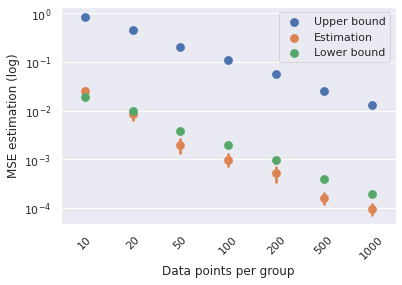

In [ ]:
sns.set()
d = len(hsls_list_significant)
m = qtd_per_group

points_per_group_est = data_per_group_est
points_MSE = np.stack((points_per_group_est, gammas), axis = 1)
column_values = ['Data points per group', 'MSE estimation (log)']
df = pd.DataFrame(data = points_MSE, 
                  columns = column_values)
a_u = np.stack((qtd_per_group, upper(d, m)), axis = 1)
a_l = np.stack((qtd_per_group, lower(d, m)), axis = 1)
a_u = pd.DataFrame(data = a_u, 
                  columns = column_values)
a_l = pd.DataFrame(data = a_l, 
                  columns = column_values)

df['Type'] = 'Estimation'
a_u['Type'] = 'Upper bound'
a_l['Type'] = 'Lower bound'

ax = sns.pointplot(data=pd.concat([a_u, df, a_l]), x="Data points per group", y="MSE estimation (log)", hue = 'Type', linestyles='', marker='o')
#ax = sns.pointplot(data= df, x="Data points per group", y="MSE estimation (log)", hue = 'Type', linestyles='', marker='o')
plt.yscale('log')
ax.set_xticklabels(qtd_per_group, rotation=45)

legend = ax.legend()
legend.texts[0]
plt.savefig('HSLS_MSE.pdf')

**Now**, we will run experiments for the hypothesis test. We will:


1.   Choose an $\epsilon$, run an threshold test with this epsilon, and plot the error probability of the test and our converse bound.
2.   We will create a heat-map to show the above experiment for different values of epsilon. 



In [ ]:
it_bootstrap = 100
epsilon = -0.15

qtd_per_group_prob = np.sort(np.array([10,20,50,100, 200,500,1000] + [d]))

per_group_num = np.zeros((qtd_per_group_prob.size)*it_bootstrap)
error_prob = np.zeros((qtd_per_group_prob.size)*it_bootstrap)
j = 0
for l in tqdm(qtd_per_group_prob):
  i = l
  error_prob_sum = 0
  dataset_slice = get_sim_dataset(hsls_pred_tabel, i, hsls_list_significant, hsls_groups, set_seed = False)

  for k in range(it_bootstrap):
    slice_accuracy_per_group = get_mean(hsls_pred_tabel, hsls_list_significant,  hsls_groups, i) 
    aux_gamma = min(slice_accuracy_per_group) 
    error_prob_sum = error_count(gamma, aux_gamma, np.array([epsilon]))
    per_group_num[j] = i
    error_prob[j] = error_prob_sum
    j = j+1

100%|██████████| 8/8 [07:45<00:00, 58.18s/it]


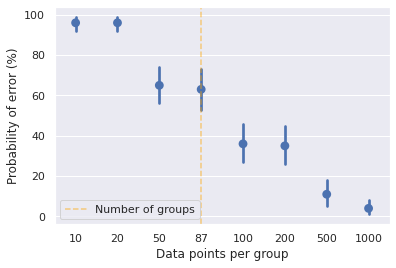

In [ ]:
points_per_group = per_group_num
points_error = np.stack((points_per_group, 100*error_prob.T), axis = 1)
column_values = ['Data points per group', 'Probability of error (%)']
df = pd.DataFrame(data = points_error, 
                  columns = column_values)
trans = np.where(d == qtd_per_group_prob)
a = sns.pointplot(data=df, x="Data points per group", y="Probability of error (%)", linestyles='', marker='o')
a.set_xticklabels(qtd_per_group_prob)
plt.axvline(trans, 0,100, color = 'orange', linestyle='--', alpha=0.5, label = 'Number of groups')
plt.legend(loc='lower left')
plt.savefig('HSLS_hyp_test.pdf')

In [ ]:
it_bootstrap = 100
epsilon = np.array([-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2])
qtd_per_group_prob = np.sort(np.array([10,20,50,100, 200,500,1000] + [d]))

error_prob_Matrix = np.zeros((qtd_per_group.size, epsilon.size))
j = 0
k = 0
for i in tqdm(qtd_per_group):
  error_prob_sum = 0
  dataset_slice = get_sim_dataset(hsls_pred_tabel, i, hsls_list_significant, hsls_groups, set_seed = False)

  for l in range(it_bootstrap):
    slice_accuracy_per_group = get_mean(hsls_pred_tabel, hsls_list_significant,  hsls_groups, i) 
    aux_gamma = min(slice_accuracy_per_group) 
    error_prob_sum += error_count(gamma, aux_gamma, epsilon)

  error_prob_Matrix[j, :] = error_prob_sum / it_bootstrap
  j = j+1

100%|██████████| 10/10 [09:48<00:00, 58.89s/it]


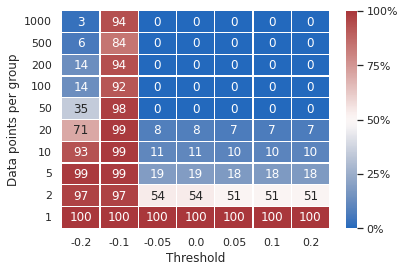

In [ ]:
sns.color_palette("vlag", as_cmap=True)
aux_prob_matrix = [[100 * l  for l in sub] for sub in error_prob_Matrix]

a = pd.DataFrame(aux_prob_matrix)

a = a.set_axis(epsilon, axis=1, inplace=False)
a = a.set_axis(qtd_per_group, axis=0, inplace=False)
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue') 
plt.rc('text', usetex='false') 
ax = sns.heatmap(a, annot=True, cmap = 'vlag',  fmt='g', linewidths=.2)
plt.xlabel('Threshold')
plt.ylabel('Data Points per Group')
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
plt.savefig('hsls_heat_hyp_test.pdf')

## Experiments with Compas
Predict whether an individual will commit a crime again in 2 years

### Preprocessing


In [ ]:
import pandas as pd
def load_data(name='adult'):
    #% Processing for COMPAS
    if name == 'compas':
        file = '../Data/compas-scores-two-years.csv'
        df = pd.read_csv(file,index_col=0)
        aux = df
        
        # select features for analysis
        df = df[['age', 'c_charge_degree', 'race',  'sex', 'priors_count', 
                    'days_b_screening_arrest',  'is_recid',  'c_jail_in', 'c_jail_out']]
        
        # drop missing/bad features (following ProPublica's analysis)
        # ix is the index of variables we want to keep.

        # Remove entries with inconsistent arrest information.
        ix = df['days_b_screening_arrest'] <= 30
        ix = (df['days_b_screening_arrest'] >= -30) & ix

        # remove entries entries where compas case could not be found.
        ix = (df['is_recid'] != -1) & ix

        # remove traffic offenses.
        ix = (df['c_charge_degree'] != "O") & ix


        # trim dataset
        df = df.loc[ix,:]

        # create new attribute "length of stay" with total jail time.
        df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])).apply(lambda x: x.days)
        
        # drop 'c_jail_in' and 'c_jail_out'
        # drop columns that won't be used
        dropCol = ['c_jail_in', 'c_jail_out','days_b_screening_arrest']
        df.drop(dropCol,inplace=True,axis=1)
        
        # rename columns 'sex' to 'gender'
        df.rename(index=str, columns={"sex": "gender"},inplace=True)
        
        # binarize degree charged
        # Misd. = -1, Felony = 1
        df.loc[:,'c_charge_degree'] = df['c_charge_degree'].apply(lambda x: 1 if x=='F' else -1)
               
        # reset index
        df.reset_index(inplace=True,drop=True)
        # Normalizing numerical features
        numerical = ['age', 'priors_count', 'length_of_stay']
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])  
        
    # TODO: add other datasets here
        
    return df

In [ ]:
# Cleaning compas dataset
compas_dataset = load_data('compas')
compas_groups = ['race', 'gender']

# Finding significant groups, i.e., counting samples per group.
compas_Counting_groups = compas_dataset.groupby(compas_groups).size().to_frame('m').reset_index()
compas_only_with_more = 20
compas_significant_groups = compas_Counting_groups[compas_Counting_groups['m'] > compas_only_with_more]
compas_list_significant = (compas_significant_groups[compas_groups]).sum(axis = 1).tolist()

# Filtering for only groups with more than adult_only_with_more elements
compas_dataset = compas_dataset[ ((compas_dataset[compas_groups]).sum(axis = 1)).isin(compas_list_significant)]
compas_dataset.head()

# Separating label (is_recid) from the rest of the data and making income binary
is_recid = compas_dataset['is_recid']
compas_dataset = compas_dataset.drop(['is_recid'], axis=1)

### Training Personalized Classifier (h_p )

In [ ]:
# Defining dataset to be used in the personalized algorithm
per_compas_dataset = compas_dataset
# One-Hot encoding
per_compas_encoded = pd.get_dummies(per_compas_dataset)
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(per_compas_encoded, is_recid, test_size = 0.5, random_state = 0)

In [ ]:
# Trining the Logistic regression classifier
logistic = LogisticRegression(solver = 'liblinear')
logistic.fit(X_train, Y_train)

#Predicting
y_test_pred = logistic.predict(X_test)
y_train_pred = logistic.predict(X_train)

In [ ]:
# Getting accuracy for the personalized classifier
per_train_acc = accuracy_score(Y_train, y_train_pred)
per_test_acc = accuracy_score(Y_test, y_test_pred)
per_train_acc, per_test_acc

(0.6778174732055863, 0.6766233766233766)

### Training Generic Classifier (h_0)

In [ ]:
# Dropping group features
gb_compas_dataset = compas_dataset.drop(compas_groups, axis = 1)

# Spliting dataset (Here we are using the same split as in ther Personalized Model)
gb_X_train, gb_X_test, gb_Y_train, gb_Y_test = train_test_split(gb_compas_dataset, is_recid, test_size = 0.5, random_state = 0)

In [ ]:
# Creating generic model
gb_logistic = LogisticRegression(solver = 'liblinear')
gb_logistic.fit(gb_X_train, gb_Y_train)

#Predicting
gb_y_test_pred = gb_logistic.predict(gb_X_test)
gb_y_train_pred = gb_logistic.predict(gb_X_train)

In [ ]:
# Accuracy group blind classifier
gb_train_acc = accuracy_score(gb_Y_train, gb_y_train_pred)
gb_test_acc = accuracy_score(gb_Y_test, gb_y_test_pred)
gb_train_acc, gb_test_acc

(0.6800909386164339, 0.6824675324675324)

### Analysis and Plots

We expect the accuracy for the group blind classifier to be smaller than the accuracy for the personalized classifier. 

Now, we will calculate the benefit of personalization. Note that here we don't have access to the true dataset distribution. Then we will resample from the test dataset $1000$ data points, estimate the BoP and define it as the group truth BoP.

For future estimations we will do the same procedure, we will resample $m$ samples with replacemente from the test dataset and estimate the BoP. 

In [ ]:
# Creating test dataframe only with group information, personalized prediction, and gb prediction

compas_pred_tabel = X_test # Only test data
compas_pred_tabel = compas_dataset.loc[compas_pred_tabel.index] 
compas_pred_tabel = compas_pred_tabel[compas_groups] # Only group attributes
GT_income = Y_test # Getting GT
GB_pred_income = gb_y_test_pred # GB prediction
Per_pred_income = y_test_pred # Personalized pred

# Canculating indicator of right prediction
compas_pred_tabel['GB Pred'] = 1 - (GT_income - GB_pred_income)**2
compas_pred_tabel['Per Pred'] =  1 - (GT_income - Per_pred_income)**2

#Generating a dataset with 1000 points per group
fake_true_data =   dataset_slice = get_sim_dataset(compas_pred_tabel, 1000, compas_list_significant, compas_groups, set_seed = True)


# Calculating accuracy for all significant groups
accuracy_per_group = fake_true_data.groupby(compas_groups).mean()

# Performance difference 
compas_pred_tabel['performance difference'] = compas_pred_tabel['Per Pred'] - compas_pred_tabel['GB Pred']

# BoP per group
BoP_Per_group = accuracy_per_group['Per Pred'] - accuracy_per_group['GB Pred']

# BoP
gamma = min(BoP_Per_group.tolist())
print('The BoP is:', gamma)

The BoP is: -0.09200000000000008


In [ ]:
accuracy_per_group['BoP_Per_Group'] = BoP_Per_group
groupMostHarmed = accuracy_per_group.idxmin().loc['BoP_Per_Group']
print(groupMostHarmed)
print(accuracy_per_group.index.names)

('Asian', 'Male')
['race', 'gender']


In [ ]:
# verify groupMostHarmed
print(accuracy_per_group.loc[groupMostHarmed]['BoP_Per_Group'] == gamma)

True


Now, Lets start to run our experiments for estimation of the BoP. 
We will resample with replacement $m$ samples per group.
After that, we will use Monte Carlo simulations to to calculate the BoP for a given $m$.

In [ ]:
montecarlo_it = 100
qtd_per_group =np.array([1, 2, 5, 10, 20,50,100,200,500,1000])
#qtd_per_group =np.array([10,25,50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 
#                      500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])

gammas = np.zeros((qtd_per_group.size) * montecarlo_it)
data_per_group_est = np.zeros((qtd_per_group.size) * montecarlo_it)
j = 0
for i in tqdm(qtd_per_group):
  gamma_sum = 0
  for l in range(montecarlo_it):
    dataset_slice = get_sim_dataset(compas_pred_tabel, i, compas_list_significant, compas_groups, set_seed = False)
    slice_accuracy_per_group = dataset_slice.groupby(compas_groups).mean()
    gammas[j] = ( min(slice_accuracy_per_group['performance difference'].tolist()) - gamma) ** 2
    data_per_group_est[j] = i
    j = j+1

100%|██████████| 10/10 [00:50<00:00,  5.02s/it]


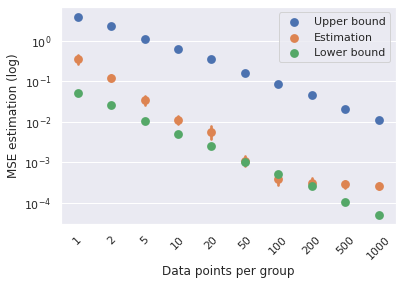

In [ ]:
sns.set()
d = len(compas_list_significant)
m = qtd_per_group

points_per_group_est = data_per_group_est
points_MSE = np.stack((points_per_group_est, gammas), axis = 1)
column_values = ['Data points per group', 'MSE estimation (log)']
df = pd.DataFrame(data = points_MSE, 
                  columns = column_values)
a_u = np.stack((qtd_per_group, upper(d, m)), axis = 1)
a_l = np.stack((qtd_per_group, lower(d, m)), axis = 1)
a_u = pd.DataFrame(data = a_u, 
                  columns = column_values)
a_l = pd.DataFrame(data = a_l, 
                  columns = column_values)

df['Type'] = 'Estimation'
a_u['Type'] = 'Upper bound'
a_l['Type'] = 'Lower bound'

ax = sns.pointplot(data=pd.concat([a_u, df, a_l]), x="Data points per group", y="MSE estimation (log)", hue = 'Type', linestyles='', marker='o')


plt.yscale('log')
ax.set_xticklabels(qtd_per_group, rotation=45)
plt.savefig('MSE_log.pdf')

legend = ax.legend()
legend.texts[0]
plt.savefig('compas_MSE.pdf')

**Now**, we will run experiments for the hypothesis test. We will:


1.   Choose an $\epsilon$, run an threshold test with this epsilon, and plot the error probability of the test and our converse bound.
2.   We will create a heat-map to show the above experiment for different values of epsilon. 



In [ ]:
it_bootstrap = 100
epsilon = -0.15

qtd_per_group_prob = np.sort(np.array([1, 2, 5, 10, 20,50,100,200,500,1000] + [d]))

per_group_num = np.zeros((qtd_per_group_prob.size)*it_bootstrap)
error_prob = np.zeros((qtd_per_group_prob.size)*it_bootstrap)
j = 0
for l in tqdm(qtd_per_group_prob):
  i = l
  error_prob_sum = 0
  dataset_slice = get_sim_dataset(compas_pred_tabel, i, compas_list_significant, compas_groups, set_seed = False)

  for k in range(it_bootstrap):
    slice_accuracy_per_group = get_mean(compas_pred_tabel, compas_list_significant,  compas_groups, i) 
    aux_gamma = min(slice_accuracy_per_group) 
    error_prob_sum = error_count(gamma, aux_gamma, np.array([epsilon]))
    per_group_num[j] = i
    error_prob[j] = error_prob_sum
    j = j+1

100%|██████████| 11/11 [00:37<00:00,  3.45s/it]


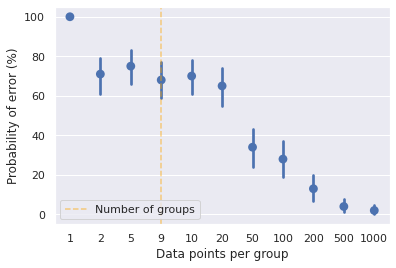

In [ ]:
points_per_group = per_group_num
points_error = np.stack((points_per_group, 100*error_prob.T), axis = 1)
column_values = ['Data points per group', 'Probability of error (%)']
df = pd.DataFrame(data = points_error, 
                  columns = column_values)
trans = np.where(d == qtd_per_group_prob)
a = sns.pointplot(data=df, x="Data points per group", y="Probability of error (%)", linestyles='', marker='o')
a.set_xticklabels(qtd_per_group_prob)
plt.axvline(trans, 0,100, color = 'orange', linestyle='--', alpha=0.5, label = 'Number of groups')
plt.legend(loc='lower left')
plt.savefig('hsls_hyp_test.pdf')

In [ ]:
it_bootstrap = 100
epsilon = np.array([-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2])
qtd_per_group_prob = np.sort(np.array([1, 2, 5, 10, 20,50,100,200,500,1000] + [d]))

error_prob_Matrix = np.zeros((qtd_per_group.size, epsilon.size))
j = 0
k = 0
for i in tqdm(qtd_per_group):
  error_prob_sum = 0
  dataset_slice = get_sim_dataset(compas_pred_tabel, i, compas_list_significant, compas_groups, set_seed = False)

  for l in range(it_bootstrap):
    slice_accuracy_per_group = get_mean(compas_pred_tabel, compas_list_significant,  compas_groups, i) 
    aux_gamma = min(slice_accuracy_per_group) 
    error_prob_sum += error_count(gamma, aux_gamma, epsilon)

  error_prob_Matrix[j, :] = error_prob_sum / it_bootstrap
  j = j+1

100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


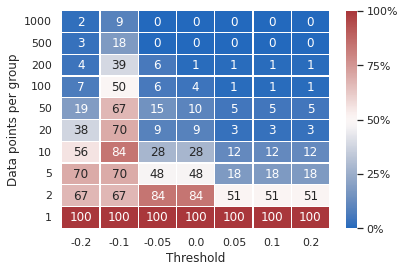

In [ ]:
sns.color_palette("vlag", as_cmap=True)
aux_prob_matrix = [[100 * l  for l in sub] for sub in error_prob_Matrix]

a = pd.DataFrame(aux_prob_matrix)

a = a.set_axis(epsilon, axis=1, inplace=False)
a = a.set_axis(qtd_per_group, axis=0, inplace=False)
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue') 
plt.rc('text', usetex='false') 
ax = sns.heatmap(a, annot=True, cmap = 'vlag',  fmt='g', linewidths=.2)
plt.xlabel('Threshold')
plt.ylabel('Data points per group')
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
plt.savefig('hsls_heat_hyp_test.pdf')